In [1]:
import numpy as np
import pandas as pd

num_classes=12
seed=42
im_size=299
batch=32

df=pd.read_csv('labels.csv')
sel_breed_list=list(df.groupby('breed').count().sort_values(by='id',ascending=False).head(num_classes).index)
df=df[df['breed'].isin(sel_breed_list)]
df['filename']=df.apply(lambda x: ('train/'+x['id']+'.jpg'),axis=1)
breeds=pd.Series(df['breed'])
print("Tot Breeds",len(breeds.unique()))
df.head()


Tot Breeds 12


,id,breed,filename
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,train/003df8b8a8b05244b1d920bb6cf451f9.jpg
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,train/0042188c895a2f14ef64a918ed9c7b64.jpg
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,train/00693b8bc2470375cc744a6391d397ec.jpg
48,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier,train/013f8fdf6d638c7bb042f5f17e8a9fdc.jpg
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu,train/0162b3e0144fb1d1ab82fbff3ace9938.jpg


In [2]:
from keras.preprocessing import image

def read_img(img_id,train_or_test,size):
    path=train_or_test+"/"+img_id+".jpg"
    img=image.load_img(path,target_size=size)
    return image.img_to_array(img)

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [6]:
from sklearn.preprocessing import LabelEncoder
label_enc=LabelEncoder()
np.random.seed(seed=seed)
rnd=np.random.random(len(df))
train_idx=rnd<0.9 
valid_idx=rnd>=0.9
y_train=label_enc.fit_transform(df["breed"].values)
ytr=y_train[train_idx]
yv=y_train[valid_idx]

In [7]:

from tqdm import tqdm
from keras.applications import xception
 
x_train = np.zeros((train_idx.sum(), im_size, im_size, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), im_size, im_size, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(df['id'])):
    img = read_img(img_id, 'train', (im_size, im_size))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))
 

1355it [00:11, 113.89it/s]


Train Images shape: (1218, 299, 299, 3) size: 326,671,254


In [10]:
from keras.layers import GlobalAveragePooling2D,Dense,BatchNormalization,Dropout
from keras.optimizers import Adam,SGD,RMSprop
from keras.models import Model,Input

base_model=xception.Xception(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    
x=base_model.output
x=BatchNormalization()(x)
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)

pred=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=pred)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rotation_range=45,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.25,horizontal_flip=True,fill_mode="nearest")
train_gen=train_datagen.flow(x_train,ytr,batch_size=batch)
valid_datagen=ImageDataGenerator()
valid_gen=valid_datagen.flow(x_valid,yv,batch_size=batch)

import datetime
from keras.callbacks import EarlyStopping,ModelCheckpoint

epochs=1
learn_rate=0.001
early_stop=EarlyStopping(monitor='val_acc',patience=5)
stamp="{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))
bst_model_path="{}.h5".format(stamp)
model_cp=ModelCheckpoint(bst_model_path,save_best_only=True,save_weights_only=False,verbose=1)
optimizer=RMSprop(lr=learn_rate,rho=0.9)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

hist=model.fit_generator(train_gen,steps_per_epoch=train_idx.sum(),epochs=epochs,callbacks=[early_stop,model_cp],validation_data=valid_gen,validation_steps=valid_idx.sum())

model.save(bst_model_path)


W0807 13:54:41.710247 24164 deprecation_wrapper.py:119] From D:\Anaconda\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 13:54:41.975072 24164 deprecation.py:323] From D:\Anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
1218/1218 [==============================] - 1334s 1s/step - loss: 0.2671 - acc: 0.9320 - val_loss: 0.0408 - val_acc: 0.9854

Epoch 00001: val_loss improved from inf to 0.04082, saving model to 2020-08-07_dog_breed_model.h5


In [17]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os

def pred_from_img(img_path):
    img=image.load_img(img_path,target_size=(299,299))
    img_tensor=image.img_to_array(img)
    img_tensor=np.expand_dims(img_tensor,axis=0)
    img_tensor/=255.0
    model_new=load_model("2020-08-07_dog_breed_model.h5")
    predict=model_new.predict(img_tensor)
    sort_breed_list=sorted(sel_breed_list)
    pred_class=sort_breed_list[np.argmax(predict)]
    plt.imshow(img_tensor[0])
    plt.axis('off')
    plt.show()
    return pred_class
    


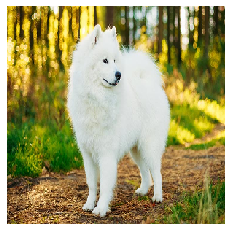

'samoyed'

In [22]:
img_path='samoyed.jpg'
pred_from_img(img_path)
